In [1]:
from paho.mqtt import client as mqtt_client
import numpy as np
import time
import matplotlib.pyplot as plt
import json
from utils import *

import sys
import time
from IPython.display import display, clear_output
import torch
from envs import OptimizationEnv
from sac import SoftActorCritic
from rlutils import ReturnTracker

In [2]:
broker = 'localhost'  # 'broker.hivemq.com'
port = 10401
client_id = 'daq-primary'
username = 'fwagner'
password = '1234'

In [3]:
env = OptimizationEnv(reset_params=False, continuous=True)

/users/felix.wagner/.local/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
env.params

{'x0': array([[-0.355218  , -0.27001468]]),
 'k': array([1.2554303]),
 'noise': 0.00356711962912585}

In [5]:
userdata = {'msg_received': 0, 
            'action': env.action_space.sample()}

client = connect_mqtt(broker, port, client_id, username, password, userdata=userdata)

In [6]:
subscribe(client, 'control/channel_0/set_control')

In [7]:
def receive_and_acknowledge(client, userdata, msg):
    
    try:
       
        data = json.loads(msg.payload)
        
        userdata['action'] = np.array([data["Action 0"], data["Action 1"]])
        
        userdata['msg_received'] += 1
        
        payload_response = {
            "Action 0": userdata["action"][0],
            "Action 1": userdata["action"][1],
        }
        
        result = client.publish('daq/channel_0/acknowledge', json.dumps(payload_response))
        check(result)
    
    except KeyError as err_msg:
        print('KeyError: ', err_msg)
        pass

In [8]:
client.on_message = receive_and_acknowledge

new_state 0 0.22223380208015442
new_state 1 -0.5896449685096741
reward -0.5444173891061618
terminated False
truncated False
steps: 165, msg received: 161


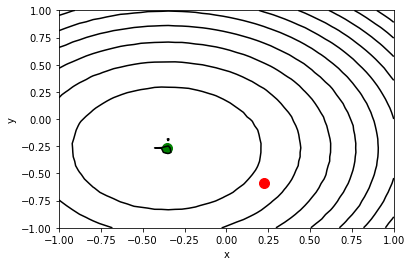

KeyboardInterrupt: 

In [9]:
terminated, truncated = False, False
    
state, info = env.reset(new_params=False)
steps = 0

while not terminated and not truncated:
    
    time.sleep(2)
    clear_output(wait=True)
    
    new_state, reward, terminated, truncated, info = env.step(userdata['action'].flatten())
        
    payload = {
        "new_state 0": float(new_state[0]),
        "new_state 1": float(new_state[1]),
        "reward": float(reward),
        "terminated": terminated,
        "truncated": truncated,
    }
    
    for k,v in zip(payload.keys(), payload.values()):
        print(k,v)

    result = client.publish('daq/channel_0/events', json.dumps(payload))
    check(result)
        
    steps += 1

    print('steps: {}, msg received: {}'.format(steps, userdata['msg_received']))

    env.render()
    sys.stdout.flush()
    
    for i in range(5):
        client.loop(.1)  # here the new action is set